# CS445 Final Project: Machine Learning Electronic Speed Control (MLESC)

By Daniel Reynolds and Zachary Fuchs

# Introduction

## Background

### What is Pulse-width Modulation

Pulse-width modulation (PWM) is a type of digital signal that can be used for a variety of applications. PWM allows for control of how long an analog signal is high compared to low over a given interval. A highly contrived example of PWM is 50/50 with a period of 2 seconds in which the signal will be high or full voltage for 1 second and low or zero voltage for the other second.

### DC Electric Motors

Direct current (DC) motors refer to a variety of different types of motors that convert direct current electric energy into mechanical energy. A simple example of a DC motor consists of a coil of wire known as the armature, a set of magnets known as the stator, and a commutator. Current is passed through the armature which creates an electromagnetic field which points in a direction controlled by the direction of the current passed through the armature. The magnets within the stator can be permanent in which the magnetic field produced is dependent on the physical position of the magnet or they can be electromagnets in which the magnetic field direction and strength can be controlled. The commutator is used to connect the coils to a source of current and can control which coil is provided current. The direction of the electromagnetic field is controlled by which coil is currently energized. By alternating which coil is energized the electromagnetic field can begin to spin which in turn creates a torque on the rotor that can then spin and be used to transfer energy to other parts of the system.

Brushless and brushed DC motors are among the most popular with brushless being much more complex than brushed. Brushed motors use conductive contacts called brushes made of carbon or graphite, or a mix of both to pass current to and from the motor. These brushes maintain contact with the commutator of the motor and allow current to flow into the armatures and ultimately produce torque to spin the rotor. Brushless DC motors do not use these brushes and require 3-phase AC power to generate the torque. Although these motors are more complex they offer higher power, efficiency, weight reduction, and longevity to the application making them a worthwhile investment for many.

### Electronic Speed Controllers

Electronic speed controllers (ESCs) are a means of controlling the current flow from the throttle to an electric motor. The basic function of an ESC is to supply a certain voltage to an electronic motor. In order to increase in speed the ESC must supply a higher voltage to the electric motor and inversely supply a lower voltage to the motor in order to decrease in speed. Modern ESCs also support the ability to act as a battery eliminator circuit, low voltage cutoff, and brake. A battery eliminator circuit is used to supply multiple devices with electricity instead of having a standalone battery for each device which would increase cost and weight of the total system. Low voltage cutoffs are used to prevent the over discharge of a battery which could cause harm to the battery itself or to other devices in the system. Braking is performed by harnessing the energy supplied by the motor to recharge the battery instead of sending energy from the battery to the motor. ESC’s typically include firmware that takes in the input signal and then controls the motor using built in logic. In this project we will be focusing on ESCs for brushed motors for simplicity and to avoid needing to convert the DC to 3-phase AC.

## What we did

### Our vehicle
<img src="bob.png"></img>

We built a small-scale electric vehicle for this project. The vehicle had two 12v brushed electric motors and had a large platform for adding our components. The vehicle had a number of components that collected state for us and would make building our end-to-end model more straightforward. 

### Our Model
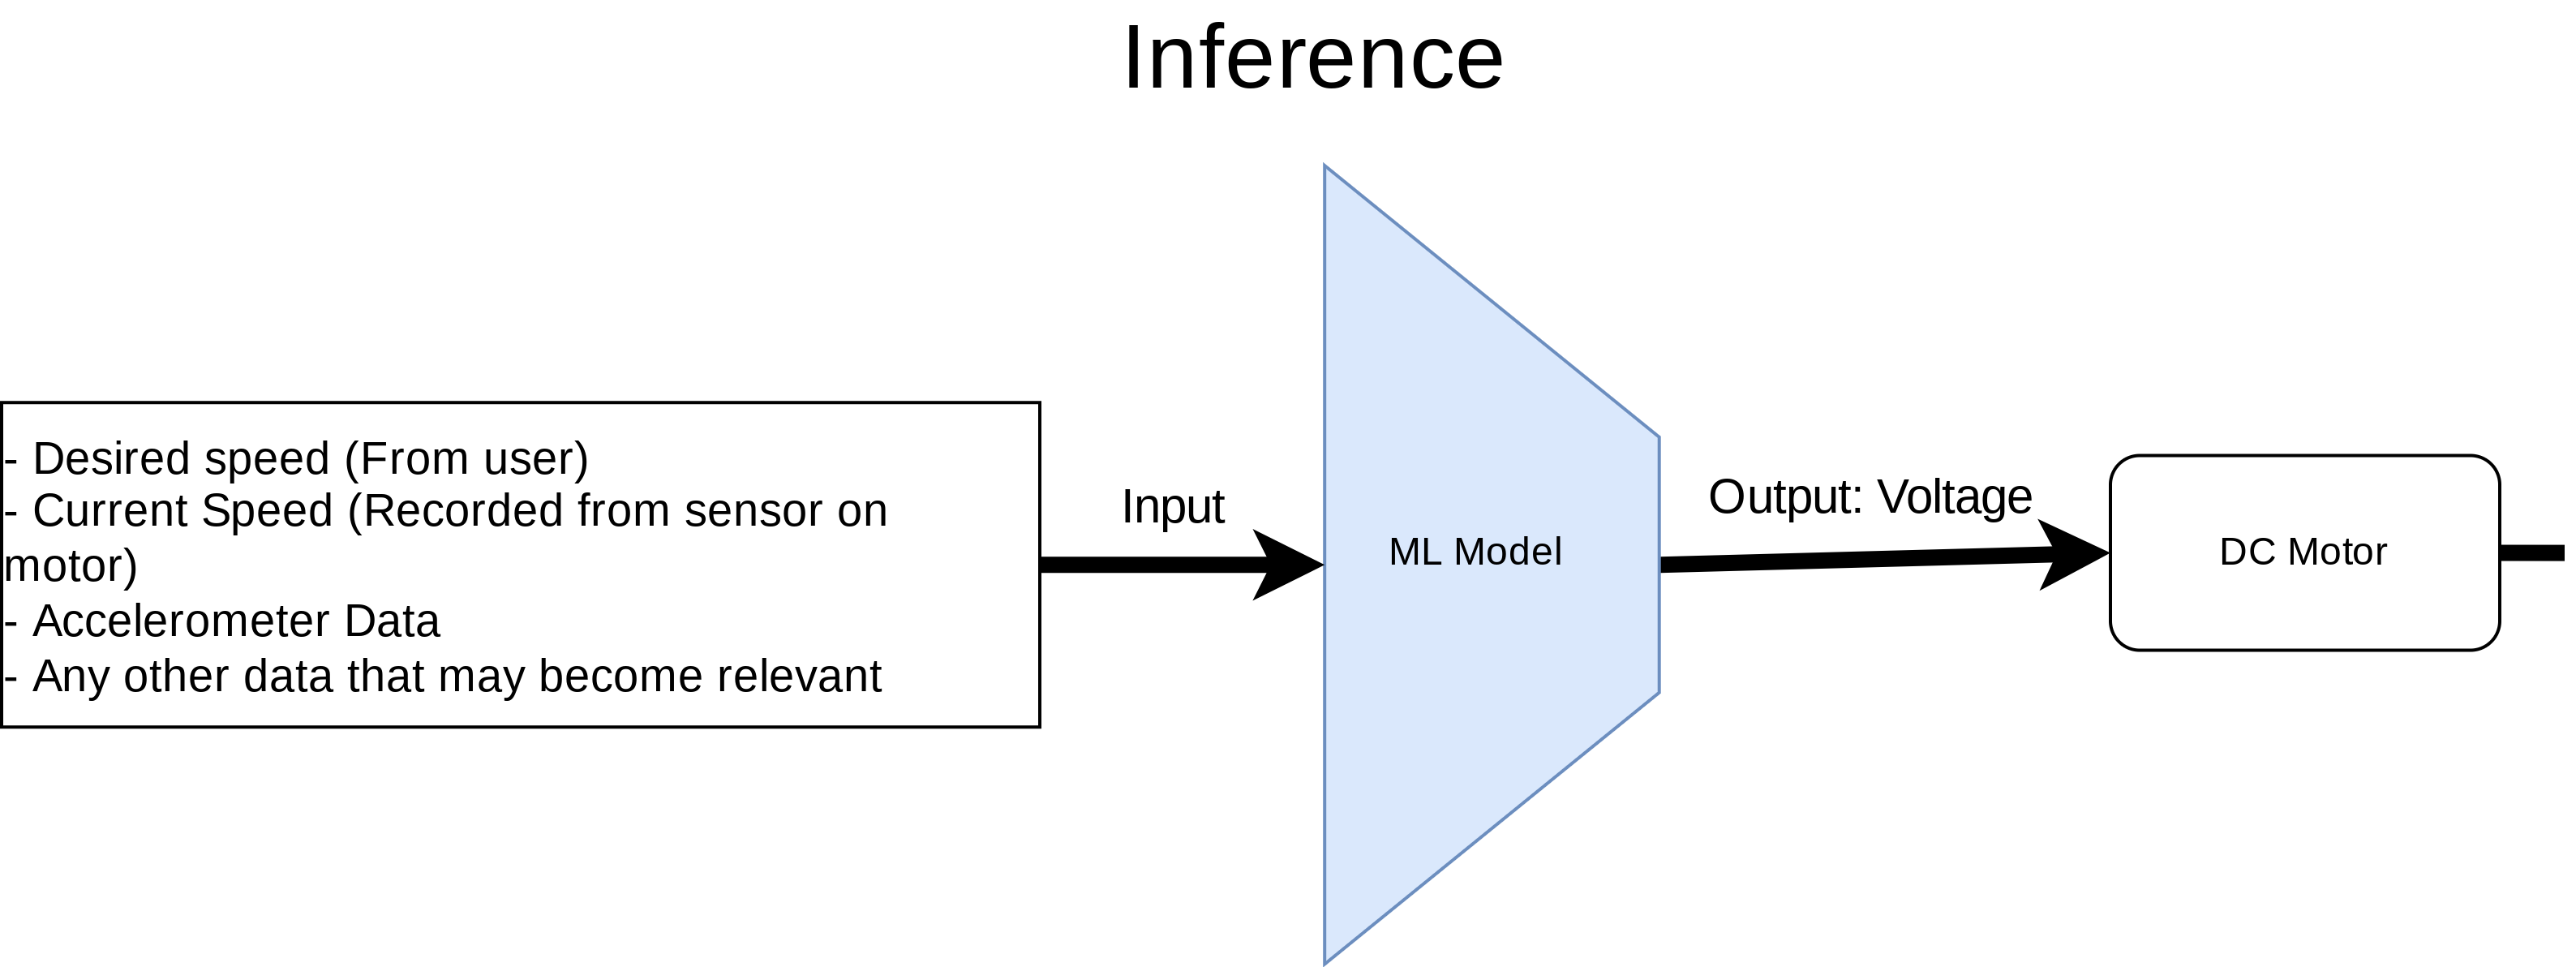

We propose a end-to-end machine-learning based solution to this problem. In our solution, we assert that the model must be able to directly set speed by modulating the voltage being output. On the input side, we have general state about the world. We experimented with a number of different model architechtures, ranging from linear regression to a massive RNN. We stuck to the approach of a direct end-to-end model which pulled state about the world and output voltage.

### Data collection and processing

We collected a dataset in which our vehicle was driven at various modulating speeds by a human driver. At set time intervals, we would collect state about the vehicle.

# Methods

We exclusively used sklearn and Keras for this project due to their low overhead and high performance. 

In [3]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-05-11 11:58:10.287185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 11:58:10.287245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data

### Data collection

Given that we are doing a real-world problem, data collection is integral. As stated, our model will emulate human actions to get to a certain speed, so collection of data is pretty straightforward. What we want is to collect as much data as possible at set time intervals. In the end, we collected the following data 30 times per second whilst a human driver drove the vehicle at varying speeds.

 - Timestamp (Milliseconds since epoch)
 - Current Voltage (Integer 0->100 representing current PWM duty cycle)
 - Current Acceleration on fore-aft axis (In m/s^2)
 - Current speed for left motor (Rotations per second)
 - Current speed for right motor (Rotations per second)
 - Average speed for left and right motor (Rotations per second)

### Data filtering

To make our analysis and model building easier, data filtering was done on the collection side of the equation. We only collected the data when the instruction to the vehicle was to drive straight, as left and right turns would skew the model with irrelevant data. The only datafiltering we performed was to remove outliers on speed that were greater than 600 rotations per second, as these appeared to be erroneous.

## Loading the data

We will use pandas dataframes to load our data.

In [5]:
data_df = pd.read_csv('./run2.csv')
data_df

,ts,duty_cycle,acc,speed_l,speed_r,speed_avg
0,1649720766813,47,1.254785,172.211955,320.644361,246.428158
1,1649720766846,45,1.091950,218.875808,300.915919,259.895864
2,1649720766879,42,-0.181992,261.883037,279.046422,270.464729
3,1649720766913,42,-0.507661,286.604091,276.845356,281.724724
4,1649720766946,41,-1.254785,317.974123,285.365871,301.669997
...,...,...,...,...,...,...
4005,1649720965510,100,-0.747124,535.741397,524.727800,530.234599
4006,1649720965543,100,-0.977008,544.934326,530.255011,537.594669
4007,1649720965577,100,-0.747124,538.252554,536.230228,537.241391
4008,1649720965610,100,0.488504,542.215801,527.598106,534.906953


### How much data?

We can see that there are 4010 rows, so if we capture data at 30 captures per second, we are looking at 4010 / 30 = 133 seconds of data. This seems quite limited but should be plenty for our analysis.

### Filter data and perform correlations

In [7]:
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","speed_avg"]]
X = data_df.to_numpy()
data_df.corr()

,duty_cycle,speed_avg
duty_cycle,1.000000,0.869815
speed_avg,0.869815,1.000000


### Note on correlations

We can see that our duty_cycle (voltage) and speed are highly correlated. So maybe we can fit a linear model?

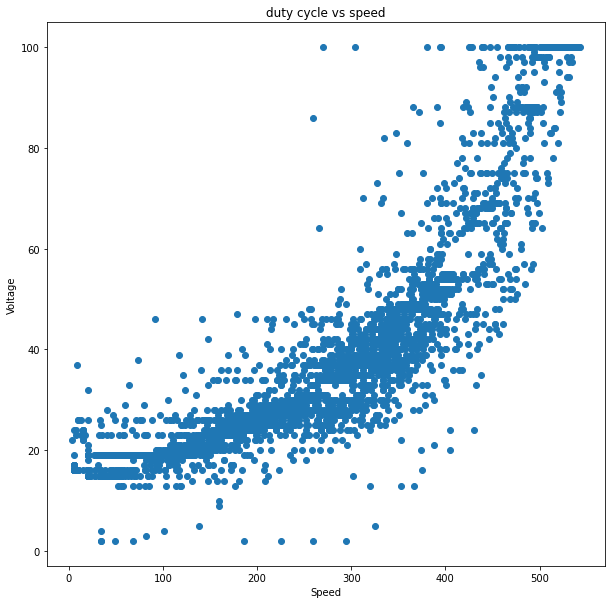

In [10]:
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(X[:,1],X[:,0]);

### Note about this graph

This isn't linear, but lets try to fit a linear regression model anyways as a baseline.

## Let's build some models

The first thing we will do is try to fit a model to all of our data. For this section, we will not focus on validation with train/test splits because we are simply trying to see if we can fit to our data. Results will actually be obtained from real-world testing of each model.

## Fit Linear Regression Model

In [12]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
speed = X[:,1].reshape(-1,1)
linreg.fit(speed,voltage)
predicted_voltage = linreg.predict(speed)
linreg.score(speed,voltage)

0.7565777246563734

### Note about $R^2$

So were looking at an $R^2$ value of about 0.76, not bad. 

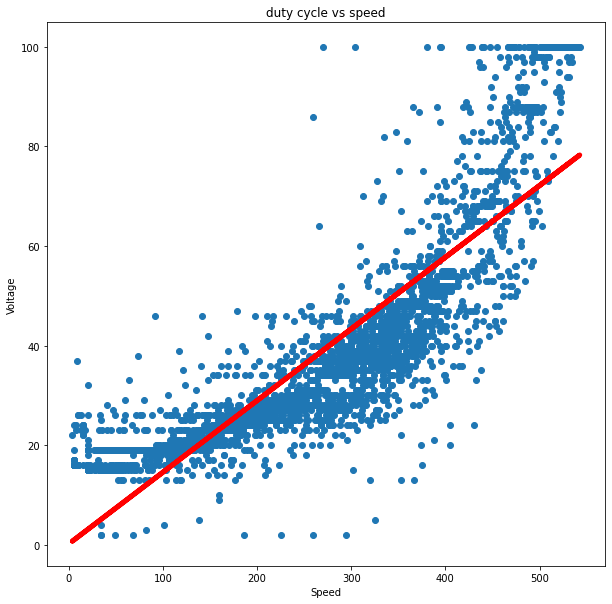

In [13]:
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(speed,voltage)
plt.plot(speed,predicted_voltage,color="red",linewidth=5.0);

### Note about this graph

Looks ok. But not great, lets see what our RMSE is and hold it as a baseline.

### Linear regression rmse

In [14]:
def rmse(A,B):
    return np.sqrt(np.mean((A-B)**2))

In [15]:
rmse(predicted_voltage,voltage)

10.790383704548834

Not a bad RMSE, but if we notice that this is on a scale from 0 to 100, we are consistently about 10 percent off, which isnt great. We also know that this model is not good at extreme values in the dataset.

## Use a min/max scaler

For our next few experiments, we want our data to be normalized between 0 and 1. Let's do that using sklearns `MinMaxScaler`.

In [16]:
speed_scaler = MinMaxScaler()
speed_scaler.fit(speed)
speed_scaled = speed_scaler.transform(speed)

## Define basic neural-net model

To fit that curve from above, we can probably just train a fairly small model to fit the data. Let's do that using a feed-forward network with one hidden layer with sigmoid activations.

In [17]:
model = keras.Sequential(
    [
        keras.Input(shape=(1,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                24        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


2022-05-11 12:22:08.442207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-11 12:22:08.442272: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-11 12:22:08.442339: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2022-05-11 12:22:08.442692: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.fit(speed_scaled, voltage / 100, epochs=250)

Epoch 1/250
125/125 [==============================] - 2s 2ms/step - loss: 0.0339
Epoch 2/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 3/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 4/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 5/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 6/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 7/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 8/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 9/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 10/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 11/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 12/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 13/250


125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 100/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 101/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 102/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 103/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 104/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 105/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 106/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 107/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 108/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 109/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 110/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 

125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 197/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 198/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 199/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 200/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 201/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 202/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 203/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 204/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 205/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 206/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 207/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 

### Plot the output

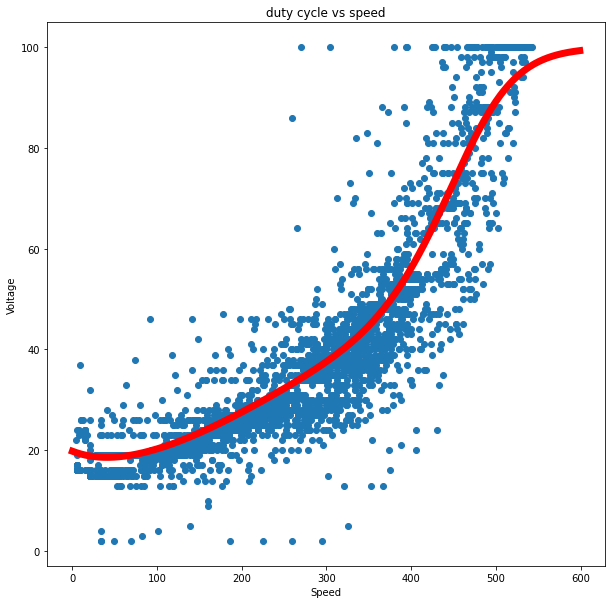

In [19]:
test_a = speed_scaler.transform(np.array(range(600)).reshape(-1,1))
predicted_voltage = model.predict(test_a) * 100

plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(speed,voltage)
plt.plot(np.array(range(600)).reshape(-1,1),predicted_voltage,color="red",linewidth=7.0);

In [20]:
predicted_voltage = model.predict(speed_scaler.transform(speed)) * 100
rmse(predicted_voltage, voltage)

7.455951106258669

Slightly better. 7.5% off though. Let's try to improve.

## With acceleration

So far, we have only done models that use speed to predict voltage. But we have a bit more data than this even at a non-temporal level. This data is necessary because it can help us deal with the variance that our model is seeing. We clearly can see that we cannot simply fit a line to our data. Let's use the acceleration data we collected and do some more analyses.

In [21]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

### Linear regression again.

In [22]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
X_actual = X[:,1:]
linreg.fit(X_actual,voltage)
predicted_voltage = linreg.predict(X_actual)
linreg.score(X_actual,voltage)

0.7583845405246178

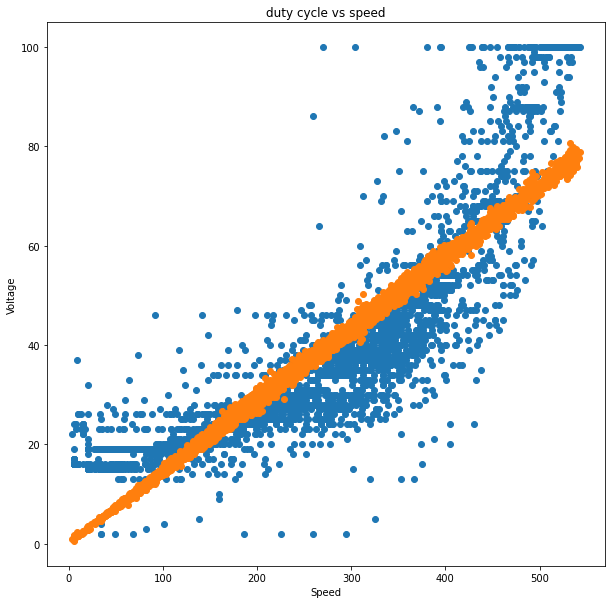

In [27]:
speed = X_actual[:,1]
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(speed, voltage)
plt.scatter(speed, predicted_voltage);

### Linear regression rmse

In [24]:
rmse(predicted_voltage, voltage)

10.750262993837906

So linear regression doesn't really do any better. Maybe a nonlinear relationship exists?

### Neural net again

In [28]:
model = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                36        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


### Scale the data

In [29]:
X_scaler = MinMaxScaler()
X_scaler.fit(X_actual)
X_scaled = X_scaler.transform(X_actual)

In [30]:
model.fit(X_scaled, voltage / 100, epochs=250)

Epoch 1/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0538
Epoch 2/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0267
Epoch 3/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 4/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 5/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 6/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 7/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 8/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 9/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 10/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 11/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 12/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 13/250


125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 100/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 101/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 102/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 103/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 104/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 105/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 106/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 107/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 108/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 109/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 110/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 

125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 197/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 198/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 199/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 200/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 201/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 202/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 203/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 204/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 205/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 206/250
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 207/250
125/125 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 

Rmse is a bit better. Still not amazing.

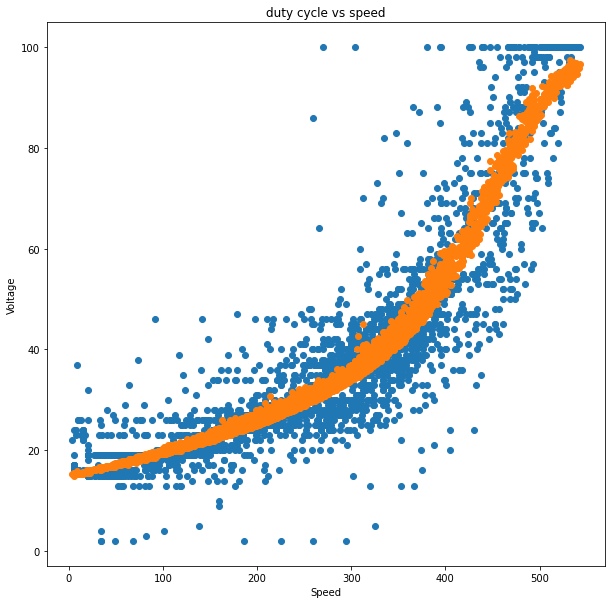

In [33]:
predicted_voltage = model.predict(X_scaled) * 100

speed = X_actual[:,1]
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(speed, voltage)
plt.scatter(speed, predicted_voltage);

In [34]:
rmse(predicted_voltage, voltage)

7.251818348428886

A tiny bit better now. The graph has a nicer aswell. So we can assert that this acceleration data offers us *something*. For the rest of the models, we will utilize this fact.

## Basic RNN
Our data has a temporal aspect. An RNN would probably be great here. Let's try.

### Define lookback as `N` (This is how much context we give to our decision)

In [35]:
N = 10

### Let's try a simple RNN first.

In [36]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,2)),
        layers.SimpleRNN(12, name="rnnlayer"),
        layers.Dense(12, activation="sigmoid", name="layer2"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnnlayer (SimpleRNN)        (None, 12)                180       
                                                                 
 layer2 (Dense)              (None, 12)                156       
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________


### Get continuous sequences from the data

The data has splits in it whenver a turn was made, so we need to find the parts that are continuous to train on.

### Build training data from the continuous sequences

In [37]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["ts","duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

timestamps = X[:,0] 
ts_diffs = timestamps[1:] - timestamps[:-1]

sequences = []
current_sequence = []

for i, diff in enumerate(ts_diffs):
    if diff < 101:
        current_sequence.append(i)
    else:
        if len(current_sequence) > N * 2:
            sequences.append(current_sequence)
        current_sequence = [i]
        
print(len(sequences))

X_relevant = X[:,2:]
Xs_scaler = MinMaxScaler()
Xs_scaler.fit(X_relevant)
X_relevant = Xs_scaler.transform(X_relevant)

# for sequence in sequences:
from sklearn.utils import shuffle

all_Xs = []
all_Ys = []
for sequence in sequences[:]:
    Xs = []
    Ys = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        Xs.append(X_relevant[indexes_x])
    all_Xs += Xs
    all_Ys += Ys

all_Xs = np.array(all_Xs)
all_Ys = np.array(all_Ys).reshape(-1,1)

all_Xs, all_Ys = shuffle(all_Xs,all_Ys)

print(all_Xs.shape, all_Ys.shape)

32
(3509, 10, 2) (3509, 1)


In [38]:
model.fit(all_Xs, all_Ys/100, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
110/110 [==============================] - 1s 4ms/step - loss: 0.0239
Epoch 2/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 3/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 7/100
110/110 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 8/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 9/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 10/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 11/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 12/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 13/100


110/110 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 100/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0027


In [40]:
predicted_voltage = model.predict(all_Xs) * 100
rmse(predicted_voltage, all_Ys)

5.138112380217057

Rmse of 5.1 is much better!

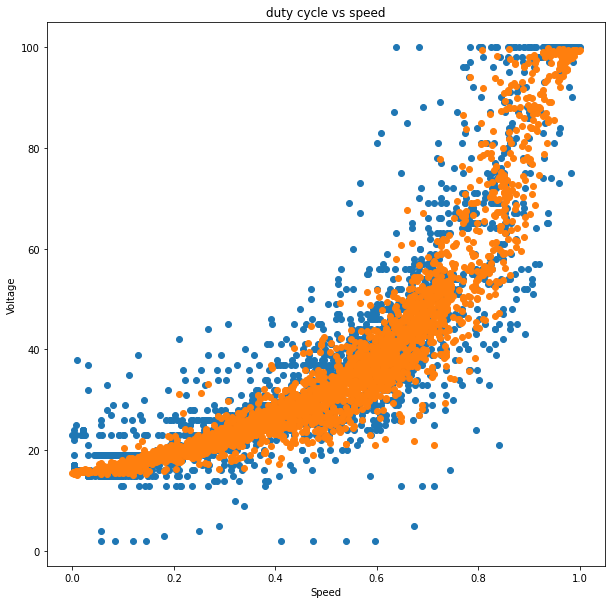

In [41]:
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(all_Xs[:,N-1,1], all_Ys)
plt.scatter(all_Xs[:,N-1,1], predicted_voltage);

Much better spread, lets save this model to test on the vehicle.

### Lets try an lstm

Maybe an lstm will better pick up on the patterns in our data.

In [43]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,2)),
        layers.LSTM(12, name="lstmlayer"),
        layers.Dense(12, activation="sigmoid", name="layer2"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstmlayer (LSTM)            (None, 12)                720       
                                                                 
 layer2 (Dense)              (None, 12)                156       
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(all_Xs, all_Ys/100, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
110/110 [==============================] - 2s 5ms/step - loss: 0.0166
Epoch 2/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0082
Epoch 3/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0061
Epoch 4/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0046
Epoch 5/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 6/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0042
Epoch 7/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0037
Epoch 8/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0035
Epoch 9/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0033
Epoch 10/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0032
Epoch 11/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0032
Epoch 12/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0030
Epoch 13/100


110/110 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 100/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0022


In [45]:
predicted_voltage = model.predict(all_Xs) * 100
rmse(predicted_voltage, all_Ys)

4.566839832428962

Even better!

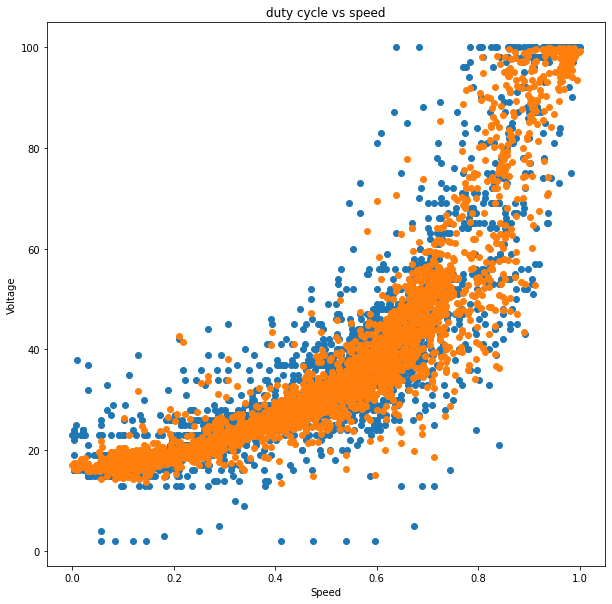

In [47]:
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(all_Xs[:,N-1,1], all_Ys)
plt.scatter(all_Xs[:,N-1,1], predicted_voltage);

### Overkill LSTM

Our RNN clearly fits our data pretty well. Let's make it much bigger and see how it does.

In [48]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,2)),
        layers.LSTM(64, name="rnnlayer"),
        layers.Dense(64, activation="relu", name="layer1"),
        layers.Dense(128, activation="relu", name="layer2"),
        layers.Dense(64, activation="relu", name="layer3"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnnlayer (LSTM)             (None, 64)                17152     
                                                                 
 layer1 (Dense)              (None, 64)                4160      
                                                                 
 layer2 (Dense)              (None, 128)               8320      
                                                                 
 layer3 (Dense)              (None, 64)                8256      
                                                                 
 out (Dense)                 (None, 1)                 65        
                                                                 
Total params: 37,953
Trainable params: 37,953
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(all_Xs, all_Ys/100, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
110/110 [==============================] - 3s 7ms/step - loss: 0.0136
Epoch 2/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0046
Epoch 3/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 4/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 5/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 6/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0034
Epoch 7/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 8/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0031
Epoch 9/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 10/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 11/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0031
Epoch 12/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0034
Epoch 13/100


110/110 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 100/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0022


In [51]:
predicted_voltage = model.predict(all_Xs) * 100
rmse(predicted_voltage, all_Ys)

5.017726841842764

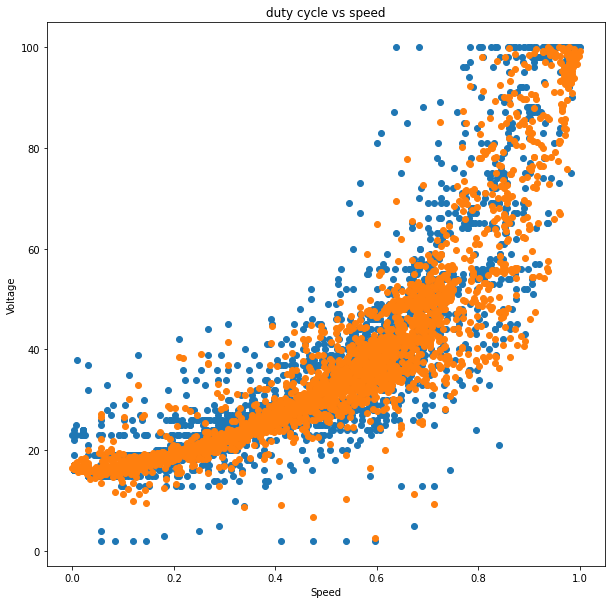

In [52]:
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(all_Xs[:,N-1,1], all_Ys)
plt.scatter(all_Xs[:,N-1,1], predicted_voltage)

Really not any better. Not worth the extra computation. Especially since we are doing the computation on the fly.

## A different approach

These approaches have a fatal flaw in the real world. What is the input for `speed` during inference?

In the real world, we have an "actual speed" and a "desired speed"

- actual speed = speed measured by the speed sensor on the vehicle
- desired speed = speed that is being asked for

For our supervised approach, we can assume that the "desired speed" for timestep $X$ is the "actual speed" at timestep $X + N$ where $N$ is how long it takes for a desire to become a reality for a human. 

Let's search for the best $N$ (how long for a desire to become actual).

To do this, we will use the same methods as the previous RNN examples, but instead of creating data with "look back" we instead will have single points with actual/desired based on the defined $N$.

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
data_df = pd.read_csv('./run2.csv')

data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["ts","duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

results = []

def get_data_n(N):
    timestamps = X[:,0] 
    ts_diffs = timestamps[1:] - timestamps[:-1]

    X_relevant = X[:,2:]
    Xs_scaler = MinMaxScaler()
    Xs_scaler.fit(X_relevant)
    X_relevant = Xs_scaler.transform(X_relevant)

    sequences = []
    current_sequence = []

    for i, diff in enumerate(ts_diffs):
        if diff < 101:
            current_sequence.append(i)
        else:
            if len(current_sequence) > N * 2:
                sequences.append(current_sequence)
            current_sequence = [i]

    print(f'num cont sequences is {len(sequences)}')

    all_Xs = []
    all_Ys = []
    for sequence in sequences[:]:
        Xs = []
        Ys = []
        for n in sequence[:-N]:
            index_actual = n
            index_desired = n + N
            Ys.append(X[index_actual,1])
            x_val = np.hstack((X_relevant[index_actual],X_relevant[index_desired, 1]))
    #         print(x_val)
            Xs.append(x_val)
        all_Xs += Xs
        all_Ys += Ys

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys).reshape(-1,1)
    return all_Xs, all_Ys

def test_n(N, verbose=0):
    all_Xs,all_Ys = get_data_n(N)

    train_Xs, test_Xs, train_Ys, test_Ys  = train_test_split(all_Xs, all_Ys, test_size=0.25, random_state=42)
        
    model = keras.Sequential(
        [
            keras.Input(shape=(3,)),
            layers.Dense(6, activation="sigmoid", name="layer1"),
            layers.Dense(6, activation="sigmoid", name="layer2"),
            layers.Dense(6, activation="sigmoid", name="layer3"),
            layers.Dense(1, name='out', activation='sigmoid')
        ]
    )
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    mc = tf.keras.callbacks.ModelCheckpoint(f'best_contextual_model_n_equals_{N}.h5', monitor='val_loss', mode='min')
    model.fit(train_Xs, train_Ys/100, validation_data=(test_Xs,test_Ys/100), epochs=5000, batch_size=32, verbose=verbose, callbacks=[es,mc])
    
    train_predicted_voltage = model.predict(train_Xs) * 100
    train_rmse = np.sqrt(np.mean((train_predicted_voltage-train_Ys)**2))
    
    test_predicted_voltage = model.predict(test_Xs) * 100
    test_rmse = np.sqrt(np.mean((test_predicted_voltage-test_Ys)**2))
    
    results.append([N,train_rmse,test_rmse])
    print(f"{N} got {train_rmse} - {test_rmse}")
    model = keras.models.load_model(f'best_contextual_model_n_equals_{N}.h5')
    return model


In [55]:
models = [test_n(n) for n in range(1,11)]

num cont sequences is 44
1 got 5.062445658575531 - 5.4874800488249385
num cont sequences is 42
2 got 4.378700308053159 - 3.8188312556477952
num cont sequences is 38
3 got 3.588087652044895 - 3.4343399322046197
num cont sequences is 37
4 got 3.546211058939732 - 3.557771121201972
num cont sequences is 37
5 got 4.067109854684675 - 4.52094203046275
num cont sequences is 35
6 got 4.328492133302935 - 4.4010267142025805
num cont sequences is 34
7 got 4.398572495251343 - 4.336771201115546
num cont sequences is 33
8 got 4.684500872753493 - 4.798759569497468
num cont sequences is 33
9 got 4.914981367763448 - 4.570671759307887
num cont sequences is 32
10 got 5.045412391773821 - 4.806298548682075


In [56]:
results = np.array(results)
pd.DataFrame(results, columns=['N', 'train rmse', 'test rmse'])

,N,train rmse,test rmse
0,1.0,5.062446,5.487480
1,2.0,4.378700,3.818831
2,3.0,3.588088,3.434340
3,4.0,3.546211,3.557771
4,5.0,4.067110,4.520942
5,6.0,4.328492,4.401027
6,7.0,4.398572,4.336771
7,8.0,4.684501,4.798760
8,9.0,4.914981,4.570672
9,10.0,5.045412,4.806299


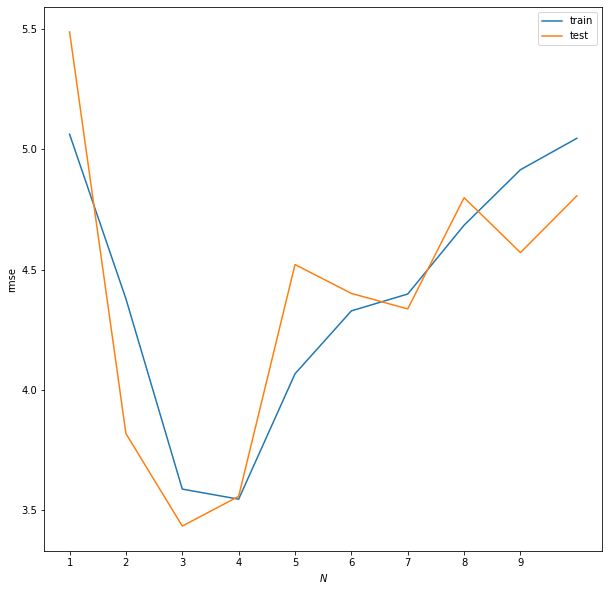

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(results[:,0],results[:,1], label="train")
plt.plot(results[:,0],results[:,2], label="test")
ax.set_xticks(np.arange(1,10))
plt.legend(loc="upper right")
plt.xlabel('$N$')
plt.ylabel("rmse")
plt.show()

It looks like 3 or 4 are great options. We will use $N=4$

### Simple Neural Net Solution to this problem

In [58]:
model = models[3]

In [63]:
all_Xs,all_Ys = get_data_n(4)
predicted_voltage = model.predict(all_Xs) * 100
rmse(predicted_voltage,all_Ys)

num cont sequences is 37


3.549105351696463

Awesome RMSE!

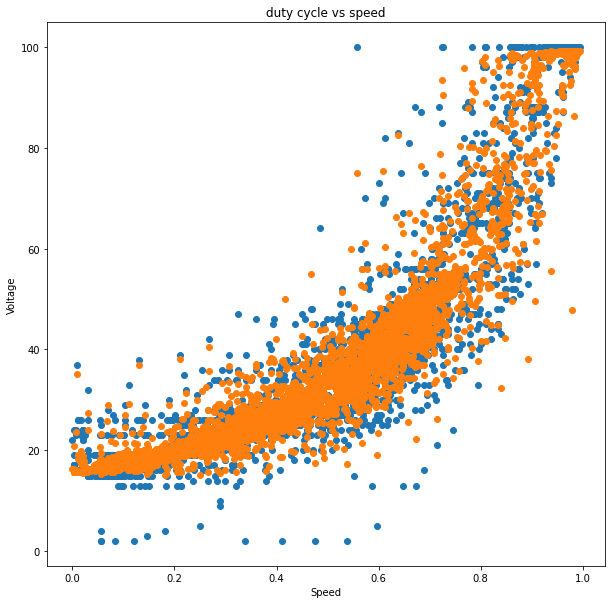

In [64]:
speed = all_Xs[:,1]
speed2 = all_Xs[:,2]
plt.figure(figsize=(10,10))
plt.title("duty cycle vs speed")
plt.xlabel("Speed")
plt.ylabel("Voltage")
plt.scatter(speed, all_Ys)
plt.scatter(speed, predicted_voltage)

So it looks like this desired/actual speed model with a $N=4$ is a very solid model.

# Results

Now that we had a good collection of models to test in the real world, all we had to do is go ahead and test them. To do this, the input to the models was set to the best available input at that moment, and the voltage output was directly sent to the motor. Here are the models that were tested and their corresponding inputs.

- **Method. (Inputs)**
- Univariate Linear regression. (Desired Speed From User).
- Multivariate Neural Net. (Desired Speed From User, Acceleration).
- Simple RNN. (Desired Speed From User, Acceleration) from the last 10 timesteps.
- Neural Net w/ Desired and Acutal Speed w/ $N=4$. (Desired Speed From User, Actual Speed of Vehicle, Acceleration).

## Note on models without "actual" speed

As stated, each of the models that only takes the desired speed from user as input, and does not actually have a semblance of actual real world speed are flawed. Basically, they have no idea how quickly they are going at a given moment, as their input for speed is based on what the user is asking for. This seriously wreaked havoc for the RNN model, which had $N$ previous inputs that were based on what the user was asking for, and not what was actually happening.

### Multivariate Linear Regression

This model performed predicatably badly, as it had a complete inability to go to full throttle. The model performed well in the "main" power band though, as this is the main thing that the line the model build fit to. This model seemed to be a worse way to control the vehicle for a human than just modulating the voltage itself. The simplicity of this model is definetly a draw though, as it allows complete explainability of the model output at any given time.

### Multivariate Neural Net

This model performed admirably for its simplicty. It fit the curve much better than the linear regression model, therefore it allowed near-full throttle at times. It also was pretty direct in that it only ever looked at one timestep. However, it felt lacking as an actual improvement over just modulating voltage. Basically, the model just felt a bit simple for how complex the problem is.

### Simple RNN

This model performed very well during training, so it was surprising to see how poorly it performed in real life. Mainly, the issue was that the previous timestep data was very flawed. The datapoints for the previous ten datapoints included "desired speed" which meant that the model was basing the speed it wanted to go on multiple datapoints relating to data that was simply desired, and not actual. This would have run on effects, as the model would act upon what it asked, and the user would try to counteract many of the results of this acting, and the cycle would repeat. 

### Neural Net w/ Desired and Acutal Speed w/ $N=4$.

This model was awesome. It felt "smart," reacting to each and every input the user gave the vehicle. Also because the $N$ was set to 4, the model only theoretically took 4 30ths of a second to react to a given input. This model felt the closest to what the plan for this project actually was, which was a simple end-to-end model which took a desired speed from the user and translated it to a voltage.

# Analysis

We have already said enough about the issues with the lack of a "actual" speed in the model input. For this section we will focus on why the "Neural Net w/ Desired and Acutal Speed w/ $N=4$." did so well. We belive that is model did very well because it accurately fit what we were asking from our model for this end-to-end solution: to emulate a human. Remember that our data comes from a human subject, therefore our model must be able to somewhat emulate what a human is *thinking* at a given moment. When we think about the human solution to the problem of setting speed given a throttle we can frame it something like this:

 - Am I going too slow? Speed up
 - Am I going too fast? Slow down
 - Am I going the correct speed? Continue on with the same output


A lower level analysis of this can be built using the concept of desired vs actual speeds. It looks something like this:

 - If $desired > actual$ Speed up
 - If $desired < actual$ Slow down
 - If $desired = actual$ Continue on with the same output

So really, we belive that this is what the model is learning, and that the simplest solution to this problem requires these "desired" and "actual" parameters. Furthermore, our model does a little bit more than "speed up" and "slow down" it lears the instructions it should before a some timestep $x$ when it wants to be at some desired speed at timestep $x+N$. This means the actions it takes are a little more fine grained than the simple binary classification model we are scaffolding.


# Conclusions

## What we learned

The main things we learned during this project is that machine learning isnt always about directly comparing different models. In our case, it was much more about what was the input of each model and understanding how that changed the way the problem was solved in an end-to-end fashion. Furthermore, thinking about the problem at hand from the perspective of which your data is modeled after appears to be a very robust approach to solving problems. 

Another lesson learned is that real-world results do not directly correlate to theoretical RMSE's, not even for validation sets. The real world is varied, and if the inputs to a model have not been thought out very well, things can devolve very quickly.

## What was hard

Honestly, thinking about how to frame this problem is the hardest thing. The whole concept of why only feeding a model a desired speed is simple enough to write about in hindsight, but was genuinely hard to wrap our heads around while we were working on it. Luckily, enough poor results meant that we reworked our model and ended up with a pretty solid solution for this problem.

## Changes made to timeline

The timeline initially included a section for reinforcement learning, but that was cut out due to time contraints and a generally good solution to the problem we were trying to solve. The timeline was stretched out a bit too, as it was a bit ambitious in timing. However, we are very happy with what we were able to create.


# References

How are DC Motors Controlled? - speed control of DC Motors. ASPINA. (n.d.). https://us.aspina-group.com/en/learning-zone/columns/what-is/011/ 

ElProCus. (2021, September 28). Electronic speed control (ESC) : Circuit, types, working &amp; its applications. ElProCus. https://www.elprocus.com/electronic-speed-control-esc-working-applications/ 

Wikimedia Foundation. (2022, March 30). DC Motor. Wikipedia. https://en.wikipedia.org/wiki/DC_motor 